### Custom Models in BoTorch
In this tutorial, we illustrate how to create a custom surrogate model using the [`Model`](https://github.com/meta-pytorch/botorch/blob/main/botorch/models/model.py) and [`Posterior`](https://github.com/meta-pytorch/botorch/blob/main/botorch/posteriors/posterior.py) interface. We will cover creating surrogate models from: 
- PyTorch distributions
- Posterior samples (using Pyro)
- Ensemble of ML predictions

This tutorial differs from the [Modular BoTorch tutorial](https://ax.dev/docs/tutorials/modular_botorch/) Ax tutorial by focusing more on authoring a new model that is compatible with the BoTorch and less on integrating a custom model with Ax's modular BoTorch model API.

In [1]:
# Install dependencies if we are running in colab
import sys
if 'google.colab' in sys.modules:
    %pip install botorch

In [2]:
import torch

# Set the seed for reproducibility
torch.manual_seed(1)
# Double precision is highly recommended for BoTorch.
# See https://github.com/meta-pytorch/botorch/discussions/1444
torch.set_default_dtype(torch.float64)

train_X = torch.rand(20, 2) * 2
Y = 1 - (train_X - 0.5).norm(dim=-1, keepdim=True)
Y += 0.1 * torch.rand_like(Y)
bounds = torch.stack([torch.zeros(2), 2 * torch.ones(2)])

Code to plot our training data.

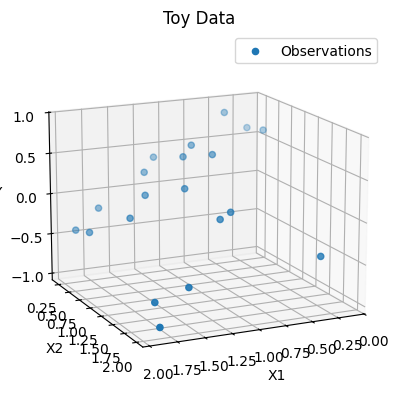

In [3]:
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from torch import Tensor
from mpl_toolkits.mplot3d import Axes3D

# Needed for older versions of matplotlib.
assert Axes3D


def plot_toy_data(x: Tensor, y: Tensor) -> Axes:
    ax = plt.figure().add_subplot(projection="3d")
    ax.scatter(
        x[:, 0].detach().numpy().squeeze(),
        x[:, 1].detach().numpy().squeeze(),
        zs=y.detach().numpy().squeeze(),
        label="Observations",
    )
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    ax.set_zlabel("Y")
    ax.set_title("Toy Data")
    ax.view_init(elev=15.0, azim=65)
    ax.legend()
    return ax


plot_toy_data(x=train_X, y=Y)
plt.show()

### Probabilistic Linear Regression (w/ Torch Distributions)
BoTorch's `Model` class only requires you to define a `posterior()` method that returns a `Posterior` object, the only requirement of which is to implement an `rsample()` function for drawing posterior samples. Specifically, we can utilize the subclass [`TorchPosterior`](https://github.com/meta-pytorch/botorch/blob/main/botorch/posteriors/torch.py) that directly wraps a [torch distribution](https://pytorch.org/docs/stable/distributions.html).

In [4]:
from typing import Optional, Union
from torch import Tensor, distributions, nn
from botorch.acquisition.objective import PosteriorTransform
from botorch.models.model import Model
from botorch.posteriors.posterior import Posterior
from botorch.posteriors.torch import TorchPosterior


class ProbabilisticRegressionModel(Model):
    _num_outputs: int

    def __init__(self, train_X: Tensor, train_Y: Tensor):
        super(ProbabilisticRegressionModel, self).__init__()
        self._num_outputs = train_Y.shape[-1]
        # Linear layer that will compute the regression output.
        self.linear = nn.Linear(train_X.shape[-1], self.num_outputs)

    @property
    def num_outputs(self) -> int:
        return self._num_outputs

    def forward(self, x: Tensor) -> distributions.Distribution:
        # For now, let's suppose we have known variance 1.
        return distributions.StudentT(df=3., loc=self.linear(x), scale=1)

    def posterior(
        self,
        X: Tensor,
        output_indices: Optional[list[int]] = None,
        observation_noise: Union[bool, Tensor] = False,
        posterior_transform: Optional[PosteriorTransform] = None,
    ) -> Posterior:
        if output_indices:
            X = X[..., output_indices]
        # TorchPosterior directly wraps our torch.distributions.Distribution output.
        posterior = TorchPosterior(distribution=self(X))
        if posterior_transform is not None:
            posterior = posterior_transform(posterior)
        return posterior


[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.

[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


In [5]:
def fit_prob_reg(
    epochs: int,
    model: ProbabilisticRegressionModel,
    optimizer: torch.optim.Optimizer,
    train_X: Tensor,
    train_Y: Tensor,
) -> None:
    """Optimization loop for linear regression."""
    train_X = train_X.requires_grad_()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(train_X)
        loss = -outputs.log_prob(train_Y).mean()
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print("epoch {}, loss {}".format(epoch, loss.item()))

In [6]:
prob_regression_model = ProbabilisticRegressionModel(train_X, Y)
optimizer = torch.optim.Adam(prob_regression_model.parameters(), lr=0.1)
fit_prob_reg(50, prob_regression_model, optimizer, train_X, Y)

epoch 0, loss 1.4067664345474094
epoch 10, loss 1.1349407118418473
epoch 20, loss 1.0426907808272752
epoch 30, loss 1.0281791195725947
epoch 40, loss 1.0313219974336634


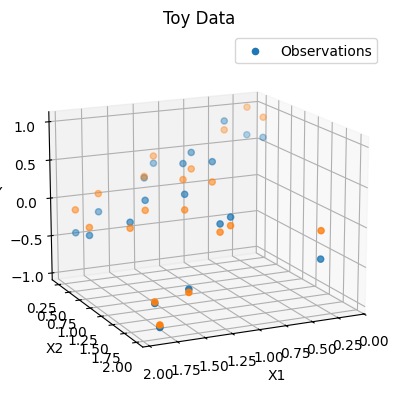

In [7]:
ax = plot_toy_data(x=train_X, y=Y)
ax.scatter(
    train_X[:, 0].detach().numpy().squeeze(),
    train_X[:, 1].detach().numpy().squeeze(),
    zs=prob_regression_model(train_X).mean.detach().squeeze().numpy(),
)
plt.show()

Finally, since our custom model is based off `Model` and `Posterior`, we can use both analytic and MC based acquisition functions for optimization.

In [8]:
from botorch.acquisition.analytic import LogExpectedImprovement
from botorch.optim.optimize import optimize_acqf

candidate, acq_val = optimize_acqf(
    LogExpectedImprovement(model=prob_regression_model, best_f=Y.max()),
    bounds=bounds,
    q=1,
    num_restarts=5,
    raw_samples=10,
)
candidate, acq_val

(tensor([[0., 0.]]), tensor(-0.1333))

Before using `qLogExpectedImprovement` we need to register an appropriate sampler for the `TorchPosterior`. We can use the following code to create a `MCSampler` for that is specific to `torch.distributions.StudentT`.

In [9]:
from botorch.sampling.base import MCSampler
from botorch.sampling.get_sampler import GetSampler
from botorch.sampling.stochastic_samplers import ForkedRNGSampler


@GetSampler.register(distributions.StudentT)
def _get_sampler_torch(
    posterior: TorchPosterior,
    sample_shape: torch.Size,
    *,
    seed: Optional[int] = None,
) -> MCSampler:
    # Use `ForkedRNGSampler` to ensure determinism in acquisition function evaluations.
    return ForkedRNGSampler(sample_shape=sample_shape, seed=seed)

In [10]:
from botorch.acquisition.logei import qLogExpectedImprovement

optimize_acqf(
    qLogExpectedImprovement(model=prob_regression_model, best_f=Y.max()),
    bounds=bounds,
    q=1,
    num_restarts=5,
    raw_samples=10,
)

(tensor([[0., 0.]]), tensor(-0.1924))

#### Supported PyTorch Distributions
Although we chose the `StudentT` distribution in the above example, any distribution supporting the `rsample` method will work with BoTorch's automatic differentiation. We can use the `has_rsample` attribute to see a complete listing of compatible distributions.

In [11]:
print(
    [
        j.__name__
        for j in [getattr(distributions, i) for i in distributions.__all__]
        if hasattr(j, "has_rsample") and j.has_rsample
    ]
)

['Beta', 'Cauchy', 'Chi2', 'ContinuousBernoulli', 'Dirichlet', 'Exponential', 'FisherSnedecor', 'Gamma', 'Gumbel', 'HalfCauchy', 'HalfNormal', 'Independent', 'InverseGamma', 'Kumaraswamy', 'Laplace', 'LogNormal', 'LogisticNormal', 'LowRankMultivariateNormal', 'MultivariateNormal', 'Normal', 'OneHotCategoricalStraightThrough', 'Pareto', 'RelaxedBernoulli', 'RelaxedOneHotCategorical', 'StudentT', 'Uniform', 'Weibull', 'Wishart', 'TransformedDistribution']


### Bayesian Linear Regression
In the previous section, we directly parameterized a "posterior" with a linear layer. In this section, we will follow Chapter 14.2 of [Bayesian Data Analysis](https://stat.columbia.edu/~gelman/book/) to implement a *proper* posterior analytically. This implementation also uses `TorchPosterior` and the `StudentT` distribution like before.

In [12]:
from typing import Optional, Union
from torch import Tensor, distributions, nn
from botorch.acquisition.objective import PosteriorTransform
from botorch.models.model import Model
from botorch.posteriors.posterior import Posterior
from botorch.posteriors.torch import TorchPosterior


def add_intercept(x: Tensor) -> Tensor:
    """Adds an intercept column to the design matrix (i.e. tensor)."""
    return torch.concat([torch.ones_like(x)[..., 0:1], x], dim=-1)


class BayesianRegressionModel(Model):
    _num_outputs: int
    df: int
    s_squared: Tensor
    beta: Tensor
    L: Tensor
    add_intercept: bool

    def __init__(self, intercept: bool = True) -> None:
        super(BayesianRegressionModel, self).__init__()
        self.add_intercept = intercept

    @property
    def num_outputs(self) -> int:
        return self._num_outputs

    def forward(self, x: Tensor) -> Tensor:
        return x @ self.beta

    def fit(self, x: Tensor, y: Tensor) -> None:
        self._num_outputs = y.shape[-1]
        x = add_intercept(x) if self.add_intercept else x
        self.df = 3.
        # Rather than V = torch.linalg.inv(x.T @ x) as in BDA
        # instead use L = torch.linalg.cholesky(x.T @ x) for stability.
        # To use L, we can simply replace operations like:
        # x = V @ b
        # with a call to `torch.cholesky_solve`:
        # x = torch.cholesky_solve(b, L)
        self.L = torch.linalg.cholesky(x.T @ x)
        # Least squares estimate
        # self.beta = torch.cholesky_solve(x.T, self.L) @ y
        self.beta = torch.cholesky_solve(x.T, self.L) @ y
        # Model's residuals from the labels.
        r: Tensor = y - self(x)
        # Sample variance
        self.s_squared = (1 / self.df) * r.T @ r

    def posterior(
        self,
        X: Tensor,
        output_indices: Optional[list[int]] = None,
        observation_noise: Union[bool, Tensor] = False,
        posterior_transform: Optional[PosteriorTransform] = None,
    ) -> Posterior:
        if output_indices:
            X = X[..., output_indices]
        if self.add_intercept:
            X = add_intercept(X)

        n, q, d = X.shape # only evaluating shape, after shape feature changes
        assert q == 1, "Only one query point is supported"
        loc = self(X)
        # Full covariance matrix of all test points.
        cov = self.s_squared * (
            torch.eye(n, n) + X.view(-1,d) @ torch.cholesky_solve(X.view(-1,d).T, self.L)
        )
        # The batch semantics of BoTorch evaluate each data point in their own batch.
        # So, we extract the diagonal representing Var[\tilde y_i | y_i] of each test point.
        scale = torch.diag(cov).reshape(n, q, self.num_outputs)
        # Form the posterior predictive dist according to Sec 14.2, Pg 357 of BDA.
        posterior_predictive_dist = distributions.StudentT(
            df=self.df, loc=loc, scale=scale
        )
        posterior = TorchPosterior(distribution=posterior_predictive_dist)
        if posterior_transform is not None:
            posterior = posterior_transform(posterior)
        return posterior

In [13]:
bayesian_regression_model = BayesianRegressionModel(intercept=True)
bayesian_regression_model.fit(train_X, Y)

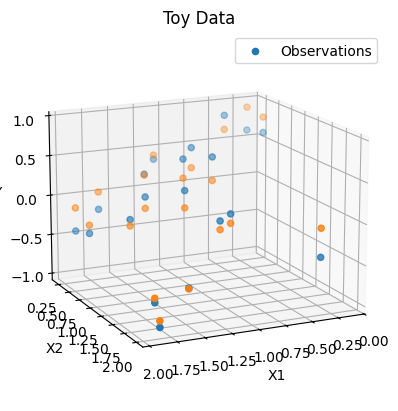

In [14]:
ax = plot_toy_data(x=train_X, y=Y)
ax.scatter(
    train_X[:, 0].detach().numpy().squeeze(),
    train_X[:, 1].detach().numpy().squeeze(),
    zs=bayesian_regression_model(add_intercept(train_X)).detach().squeeze().numpy(),
)
plt.show()

In [15]:
optimize_acqf(
    LogExpectedImprovement(model=bayesian_regression_model, best_f=Y.max()),
    bounds=bounds,
    q=1,
    num_restarts=5,
    raw_samples=10,
)

(tensor([[0., 0.]]), tensor(-0.9797))

In [16]:
optimize_acqf(
    qLogExpectedImprovement(model=bayesian_regression_model, best_f=Y.max()),
    bounds=bounds,
    q=1,
    num_restarts=5,
    raw_samples=10,
)

(tensor([[0., 0.]]), tensor(-1.0001))

### Bayesian Linear Regression w/ `EnsemblePosterior`
The `EnsembleModel` class provides a default implementation for `posterior()`. Then the MC acquisition function will be optimized using samples from the posterior predictive distribution (`EnsemblePosterior` also implements `mean` and `variance` properties, so some other analytic acquisition functions will also work). We follow this [Pyro tutorial](https://pyro.ai/examples/bayesian_regression.html#Bayesian-Regression-with-Pyro%E2%80%99s-Stochastic-Variational-Inference-(SVI)) for a linear regression model fit with [Stochastic Variational Inference](https://pyro.ai/examples/svi_part_i.html) (SVI).

First, we define a Pyro model capable of sampling from a posterior predictive distribution for new observations at test points. Later, when we perform posterior predictive inference, we will use Pyro's [`Predictive`](https://docs.pyro.ai/en/dev/_modules/pyro/infer/predictive.html) class. By default, `Predictive` ignores inference gradients with:

```python
model = torch.no_grad()(poutine.mask(model, mask=False) if mask else model)
```

Since we need to retain the autograd graph to optimize the acquisition function, we can use `torch.set_grad_enabled(True)` in the `forward()` method to override this behavior.

In [17]:
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoGuide, AutoDiagonalNormal
from pyro.nn import PyroSample, PyroModule
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import PyroOptim

pyro.set_rng_seed(1)


# Bayesian Regression represented as a single hidden layer.
class BayesianRegression(PyroModule):
    Y: str = "y"

    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        # Linear layer like before, but wrapped with PyroModule.
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        # Add priors to the weights & bias of the linear layer.
        self.linear.weight = PyroSample(
            dist.Normal(0.0, 1.0)
            .expand(torch.Size([out_features, in_features]))
            .to_event(2)
        )
        self.linear.bias = PyroSample(
            dist.Normal(0.0, 10.0).expand(torch.Size([out_features])).to_event(1)
        )

    def forward(self, x: Tensor, y: Optional[Tensor] = None) -> Tensor:
        # NOTE: Enable gradient tracking to override behavior of `Predictive`.
        torch.set_grad_enabled(True)
        # Prior for the noise level.
        sigma = pyro.sample("sigma", dist.Uniform(0.0, 10.0))
        # Linear layer on the inputs.
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            # Observations will be t distributed.
            t_dist = dist.StudentT(df=3., loc=mean, scale=sigma)
            _ = pyro.sample(self.Y, t_dist, obs=y)
        return mean

In [18]:
def fit_svi(
    epochs: int,
    model: PyroModule,
    guide: AutoGuide,
    optimizer: PyroOptim,
    train_X: Tensor,
    train_Y: Tensor,
) -> None:
    svi = SVI(
        model,
        guide,
        optimizer,
        loss=Trace_ELBO(),
    )
    pyro.clear_param_store()
    for epoch in range(epochs):
        loss = svi.step(train_X, train_Y.squeeze())
        if epoch % 10 == 0:
            print("epoch {}, loss {}".format(epoch, loss))

Now, we incorporate our Pyro model into the `Model` and `Posterior` interface like before. `EnsemblePosterior` expects a `(b) x s x q x m` tensor where `m` is the output size of the model and `s` is the ensemble size.

In [19]:
from botorch.models.ensemble import EnsembleModel
from pyro.infer import Predictive

class EnsembleBayesianRegressionModel(EnsembleModel):
    model: BayesianRegression
    guide: AutoGuide
    num_samples: int
    _num_outputs: int

    def __init__(self, train_X: Tensor, train_Y: Tensor, num_samples: int = 100):
        super(EnsembleBayesianRegressionModel, self).__init__()
        self._num_outputs = train_Y.shape[-1]
        self.model = BayesianRegression(train_X.shape[-1], self.num_outputs)
        self.guide = AutoDiagonalNormal(self.model)
        self.num_samples = num_samples

    def forward(self, X: Tensor) -> Tensor:
        predictive = Predictive(
            self.model,
            guide=self.guide,
            num_samples=self.num_samples,
            # Only return the posterior predictive distribution for y.
            return_sites=(self.model.Y,),
        )
        # `EnsemblePosterior` expects a `(b) x s x q x m` tensor where `m` is the
        # output size of the model and `s` is the ensemble size.
        samples = (
            # Retrieve posterior samples from the observation random variable.
            # This is also known as a posterior predictive distribution.
            predictive(X.squeeze())[self.model.Y]
            # Move the ensemble dimension to "s" axis.
            .transpose(0, 1)
            # Reshape for `EnsemblePosterior` as mentioned above.
            .reshape(X.shape[0], -1, 1, self.num_outputs)
        )
        return samples

In [20]:
ensemble_bayesian_regression_model = EnsembleBayesianRegressionModel(
    train_X=train_X, train_Y=Y
)
fit_svi(
    100,
    ensemble_bayesian_regression_model.model,
    ensemble_bayesian_regression_model.guide,
    pyro.optim.Adam({"lr": 0.1}),
    train_X,
    Y,
)

epoch 0, loss 59.37405385761919
epoch 10, loss 48.79479142734722
epoch 20, loss 29.677412358109535
epoch 30, loss 33.595642536471374
epoch 40, loss 60.80503562352028
epoch 50, loss 32.28590365199918
epoch 60, loss 31.121783653622437
epoch 70, loss 22.872947363325885
epoch 80, loss 11.57020110841609
epoch 90, loss 16.88730015913127


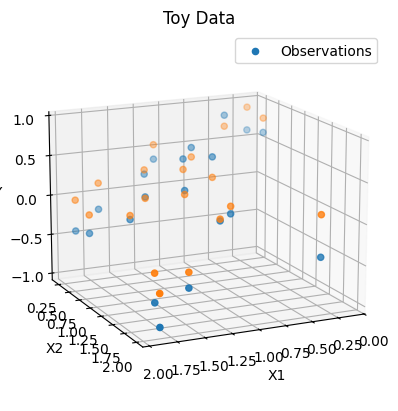

In [21]:
ax = plot_toy_data(x=train_X, y=Y)
ax.scatter(
    train_X[:, 0].detach().numpy().squeeze(),
    train_X[:, 1].detach().numpy().squeeze(),
    zs=ensemble_bayesian_regression_model(train_X)
    .detach()
    .squeeze()
    .mean(dim=-1)
    .numpy(),
)
plt.show()

In [22]:
optimize_acqf(
    LogExpectedImprovement(model=ensemble_bayesian_regression_model, best_f=Y.max()),
    bounds=bounds,
    q=1,
    num_restarts=5,
    raw_samples=10,
)

(tensor([[0., 0.]]), tensor(-1.1305))

In [23]:
optimize_acqf(
    qLogExpectedImprovement(model=ensemble_bayesian_regression_model, best_f=Y.max()),
    bounds=bounds,
    q=1,
    num_restarts=5,
    raw_samples=10,
)

(tensor([[0., 0.]]), tensor(-1.1052))

### Random Forest w/ Ensemble Posterior
Finally, we move away from linear models to any ML technique that ensembles many models. Specifically, we can use the [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) from sklearn which is an ensemble method of individual decision trees. These decision trees can be accessed through the object's `estimators_` attribute.

In [24]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from botorch.models.ensemble import EnsembleModel


class EnsembleRandomForestModel(EnsembleModel):
    model: RandomForestRegressor
    num_samples: int
    _num_outputs: int

    def __init__(self, num_samples: int = 100):
        super(EnsembleRandomForestModel, self).__init__()
        self._num_outputs = 1
        self.model = RandomForestRegressor(n_estimators=num_samples)

    def fit(self, X: Tensor, y: Tensor) -> None:
        self.model = self.model.fit(
            X=X.detach().numpy(), y=y.detach().numpy().squeeze()
        )

    def forward(self, X: Tensor) -> Tensor:
        x = X.detach().numpy().squeeze()
        # Create the ensemble from predictions from each decision tree.
        y = torch.from_numpy(np.array([i.predict(x) for i in self.model.estimators_]))
        # `EnsemblePosterior` expects a `(b) x s x q x m` tensor where `m` is the
        # output size of the model and `s` is the ensemble size.
        samples = y.transpose(0, 1).reshape(X.shape[0], -1, 1, self.num_outputs)
        return samples

In [25]:
ensemble_random_forest_model = EnsembleRandomForestModel(num_samples=300)
ensemble_random_forest_model.fit(X=train_X, y=Y)

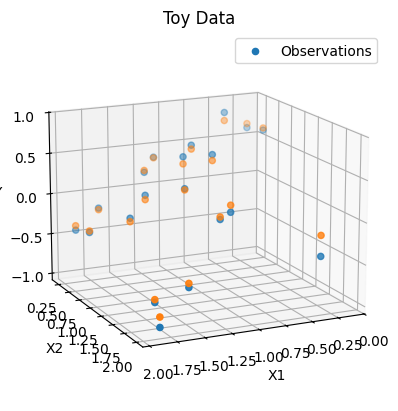

In [26]:
ax = plot_toy_data(x=train_X, y=Y)
ax.scatter(
    train_X[:, 0].detach().numpy().squeeze(),
    train_X[:, 1].detach().numpy().squeeze(),
    zs=ensemble_random_forest_model(train_X).detach().squeeze().mean(dim=-1).numpy(),
)
plt.show()

In order to use gradient-based optimization of the acquisition function (via the standard `optimize_acqf()` method) we will need to have the samples drawn from the posterior be differentiable w.r.t. to the input to the `posterior()` method (this is not the case for Random Forest models). Instead, we will perform the acquisition function optimization with gradient-free methods.

In [27]:
optimize_acqf(
    LogExpectedImprovement(model=ensemble_random_forest_model, best_f=Y.max()),
    bounds=bounds,
    q=1,
    num_restarts=5,
    raw_samples=10,
    options={"with_grad": False},
)

(tensor([[0.5480, 0.3606]]), tensor(-3.5043))

In [28]:
optimize_acqf(
    qLogExpectedImprovement(model=ensemble_random_forest_model, best_f=Y.max()),
    bounds=bounds,
    q=1,
    num_restarts=5,
    raw_samples=10,
    options={"with_grad": False},
)

(tensor([[0.7104, 0.1625]]), tensor(-15.0281))

#### CMA-ES
We can also move the optimization loop out of BoTorch entirely and follow the [CMA-ES tutorial](https://botorch.org/docs/tutorials/optimize_with_cmaes) to optimize with an evolution strategy.

In [29]:
import cma
import numpy as np

x0 = np.random.rand(2)

es = cma.CMAEvolutionStrategy(
    x0=x0,
    sigma0=0.2,
    inopts={"bounds": [0, 2], "popsize": 50},
)

log_expected_improvement_ensemble_random_forest_model = LogExpectedImprovement(
    model=ensemble_random_forest_model, best_f=Y.max()
)

with torch.no_grad():
    while not es.stop():
        xs = es.ask()
        y = (
            -log_expected_improvement_ensemble_random_forest_model(
                torch.from_numpy(np.array(xs)).unsqueeze(-2)
            )
            .view(-1)
            .double()
            .numpy()
        )
        es.tell(xs, y)

torch.from_numpy(es.best.x)

(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 2 (seed=961778, Thu Jan  8 11:25:20 2026)


tensor([0.3717, 0.3248])